In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [16]:
# CdSe/ZnS core-shell quantum dots

# file = 'C:/Users/HP/Downloads/TimeTagsPulsed_10MHz_2024-11-29_131209.ttbin' #QD_33 (PW) (Antibunching 0.401)
# file = 'C:/Users/HP/Downloads/TimeTagsPulsed_10MHz_2024-11-29_154713.ttbin' #QD_34 (PW) (Antibunching 0.279)
file = 'C:/Users/HP/Downloads/TimeTagsPulsed_10MHz_2024-11-29_161622.ttbin' #QD_35 (PW) (Antibunching 0.221)
# file = 'C:/Users/HP/Downloads/TimeTagsPulsed_10MHz_2024-11-29_170933.ttbin' #QD_37 (PW) (Antibunching 0.373)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-02_124346.ttbin' #QD_38 (PW) (Antibunching 0.562)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-02_160528.ttbin' #QD_39 (PW) (Antibunching 0.354)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-02_163149.ttbin' #QD_40 (PW) (Antibunching 0.316)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-03_104522.ttbin' #QD_41 (PW) (Antibunching 0.450)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-03_121319.ttbin' #QD_42 (PW) (Antibunching 0.310)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_5MHz_2024-12-03_124708.ttbin' #QD_43 (PW) (Antibunching 0.311) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-01-22_124946.ttbin' #QD_45 (PW) (Antibunching 0.540) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-01-23_161153.ttbin' #QD_47 (PW) (Antibunching 0.393) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-01-23_163432.ttbin' #QD_48 (PW) (Antibunching 0.527) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-01-23_163432.ttbin' #QD_49 (PW) (Antibunching 0.527) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-02-19_144007.ttbin' #QD_55 (PW) (Antibunching ) 
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-02-19_153646.ttbin' #QD_56 (PW) (Antibunching 0.261) (Big rep. rate)

In [3]:
# C_60 molecules

# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_133235.ttbin' #QD_18 (PW) (Antibunching 0.596)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_135704.ttbin' #QD_20 (PW) (Antibunching 0.785)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_141548.ttbin' #QD_21 (PW) (Antibunching 0.538)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_163955.ttbin' #QD_23 (PW 1) (Antibunching 0.810)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_164301.ttbin' #QD_23 (PW 2) (Antibunching 0.732)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_170035.ttbin' #QD_23 (PW 3) (Antibunching 0.715)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_171013.ttbin' #QD_23 (PW 4) (Antibunching 0.857)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-05_172322.ttbin' #QD_24 (PW) (Antibunching 0.492)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_143420.ttbin' #QD_27 (PW) (Antibunching 0.741)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_144431.ttbin' #QD_28 (PW) (Antibunching 0.609)
file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_153714.ttbin' #QD_29 (PW) (Antibunching 0.308)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-07_100735.ttbin' #QD_30 (PW) (Antibunching 0.254)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_124542.ttbin' #QD_36 (PW) (Antibunching 0.344) (0.2 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_125253.ttbin' #QD_37 (PW) (Antibunching 0.344) (0.3 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-17_132341.ttbin' #QD_40 (PW) (Antibunching 0.269) (0.2 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-03-10_153418.ttbin' #QD_48 (PW) (Antibunching 0.619) (0.160 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-03-10_153454.ttbin' #QD_48 (PW) (Antibunching 0.388) (0.160 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-03-10_153619.ttbin' #QD_48 (PW) (Antibunching 0.369) (0.160 uW)
# file = 'C:/Users/HP/Downloads/TimeTags_PW_2025-03-10_160412.ttbin' #QD_49 (PW) (Antibunching 0.396) (0.10 uW)

In [42]:
file = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\TimeTagger\20251215\TimeTags_PW_2025-12-15_113237.ttbin'  
file = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\TimeTagger\20251215\TimeTags_PW_2025-12-15_180250.ttbin'  

In [43]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (3, 4, 6)
Has data? -> True


In [44]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-12-15 18:02:50 +0100
devices: [{'FPGA ID': 12424485947926612, 'PCB version': '1.7 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '22440012XD'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [True, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 8.0, 'test signal': False, 'trigger level': 0.5, 'trigger level range': [-2.5, 2.5]}, {'average rising falling': [False, False], 'c

In [45]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2025-12-17 12:14:38 +0100',
 'deprecated replay scheme': True,
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.19.0',
 'virtual inputs': []}


Correlation measurement is running.

Rate of counts channel 3 (counts/sec) : 6528.859078948909
Total counts channel 3 : 1977320
Rate of counts channel 4 (counts/sec) : 6056.43372579522
Total counts channel 4 : 1834242


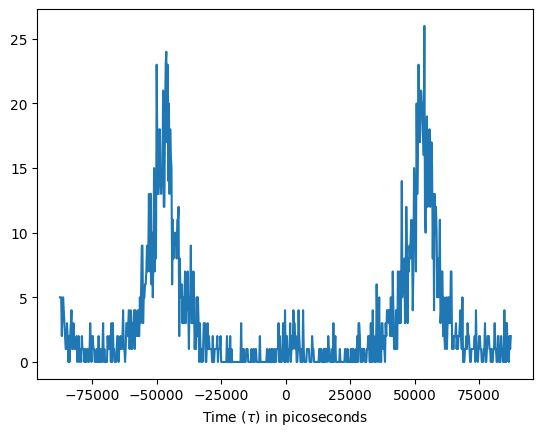

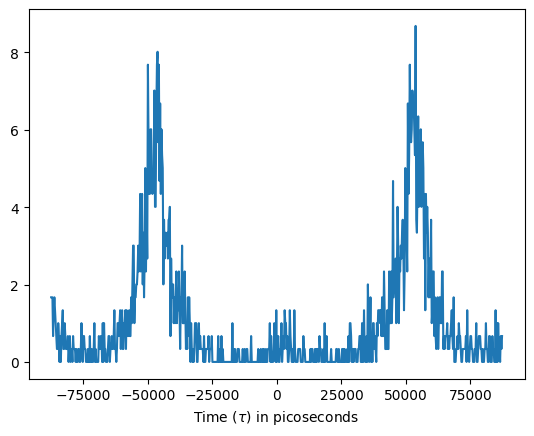

In [46]:
# measure photon antibunching
corr_ch1 = config['registered channels'][2] # first photon channel for antibunching measurements
corr_ch2 = config['registered channels'][3] # second photon channel for antibunching measurements
bwcorr = 250 # 1 ns
nbins = 700

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

rate_ch1 = cr.getData()[0]
rate_ch2 = cr.getData()[1]
counts_ch1 = cr.getCountsTotal()[0]
counts_ch2 = cr.getCountsTotal()[1]

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

In [47]:
# Normalize counts 
capture_duration = np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]) * 1e12 # Capture duration in picoseconds
print("Capture duration (seconds): ", np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]))

counts_normalized = (ycorr  * capture_duration)/(bwcorr * counts_ch1 * counts_ch2) 

Capture duration (seconds):  302.85842841600004


In [54]:
rep_rate = 50 #ns (Repetition rate of the pulsed laser)

In [55]:
# Define the fitting function: 
def fitting_function(tau, a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right):
    return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))


# Function to normalize counts and fit the data
def fit_noblinking(tau, counts):
    # Initial parameter guess [a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right]
    global rep_rate
    p0 = [1, 1, -rep_rate, 5, 5, 0, 10, 1, rep_rate, 5]
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)
    
    return popt, pcov

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, params, width, height, font_size):
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 1000000)
    fitted_curve = fitting_function(tau_fine, *params)
    
    # Cálculo del error como raíz cuadrada de counts
    errors = np.sqrt(counts)
    # Crear la figura
    plt.figure(figsize=(width, height))
    # Banda de error: área sombreada entre (counts - error) y (counts + error)
    plt.fill_between(tau, counts - errors, counts + errors, color="#0004FF", alpha=0.2)
    # Línea ajustada
    plt.plot(tau_fine, fitted_curve, color="#0004FF", linestyle='-', linewidth = 0.8)
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # Activar la cuadrícula
    plt.grid(True)
    # Mostrar el gráfico
    plt.show()
    # Mostrar
    plt.tight_layout()
    plt.show()
    
def plot_fit_noblinking_norm(tau, counts, params, width, height, font_size):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, linestyle='-', color='black', linewidth=0.7, label='Normalized Data')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 1000000)
    fitted_curve = fitting_function(tau_fine, *params)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'g-', label='Fitted Curve')
    
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.legend()
    plt.grid(True)
    plt.show()

## Obtention of non-normalized graph

In [56]:
params, pcov = fit_noblinking(xcorr/1000, ycorr)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: 0.643 ± 0.104 counts
b_left: 19.965 ± 0.568 counts
t_0_left: -46.693 ± 0.112 ns
tau_0_left: 5.549 ± 0.251 ns 

b: 2.802 ± 1.610 counts
t_0: 3.132 ± 0.294 ns
tau_0: 0.742 ± 0.610 ns 

b_right: 20.127 ± 0.573 counts
t_0_right: 52.935 ± 0.110 ns
tau_0_right: 5.448 ± 0.246 ns 



C:\Users\raul.lahoz.sanz\AppData\Local\Temp\ipykernel_13848\4009330795.py:3: RuntimeWarning: overflow encountered in exp
  return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))
C:\Users\raul.lahoz.sanz\AppData\Local\Temp\ipykernel_13848\4009330795.py:3: RuntimeWarning: overflow encountered in multiply
  return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))


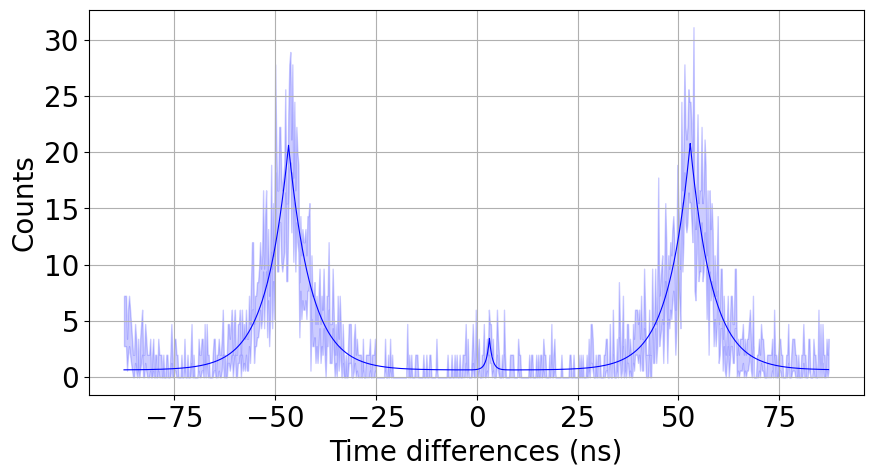

<Figure size 640x480 with 0 Axes>

In [57]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, ycorr, params, width=10, height=5, font_size=20)

## Obtention of the normalized graph

In [52]:
popt, pcov = fit_noblinking(xcorr/1000, counts_normalized)
# Extract fitted parameters
a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right = popt

counts_normalized = 2 * counts_normalized/ (b_left + b_right)

params, pcov = fit_noblinking(xcorr/1000, counts_normalized)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: -0.859 ± inf counts
b_left: -8746.898 ± inf counts
t_0_left: 42889.009 ± inf ns
tau_0_left: 290.977 ± inf ns 

b: 1.099 ± inf counts
t_0: 0.298 ± inf ns
tau_0: 19.033 ± inf ns 

b_right: -9698.996 ± inf counts
t_0_right: -47785.550 ± inf ns
tau_0_right: 251.805 ± inf ns 



C:\Users\raul.lahoz.sanz\AppData\Local\Temp\ipykernel_13848\4009330795.py:3: RuntimeWarning: overflow encountered in exp
  return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))
C:\Users\raul.lahoz.sanz\AppData\Local\Temp\ipykernel_13848\4009330795.py:3: RuntimeWarning: invalid value encountered in add
  return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))
C:\Users\raul.lahoz.sanz\AppData\Local\Temp\ipykernel_13848\4009330795.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)


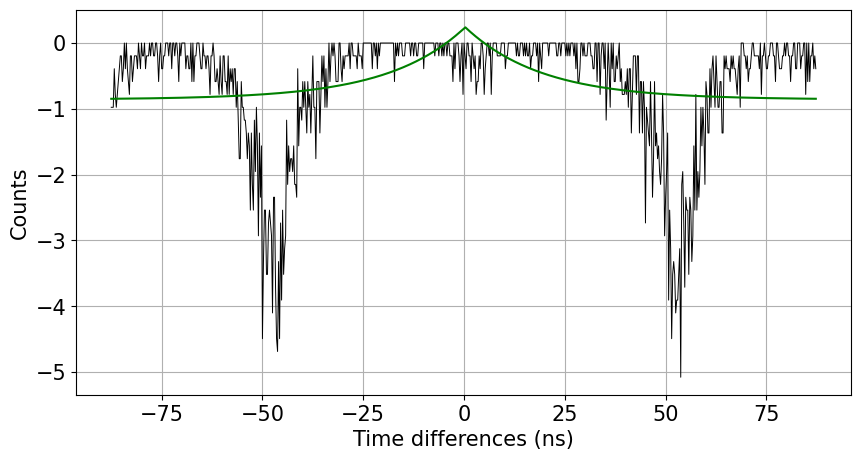

In [53]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking_norm(xcorr/1000, counts_normalized, params, width=10, height=5, font_size=15)

In [15]:
print(f"Normalized g^(2)(tau = 0): {(params[0] + params[4]):.3f} ± {np.sqrt((perr[0]**2 + perr[4]**2)):.3f}")

Normalized g^(2)(tau = 0): 0.304 ± 0.024
